# Model Evaluation - Training Results Review

Quick inspection of training results to decide if model is worth evaluating on test set.

**Purpose**: Load latest trained model and review training metrics/visualizations before running full evaluation.

**Steps**:
1. Load training history from latest run
2. Visualize training curves (loss, accuracy, F1)
3. Review metrics and identify issues
4. If satisfactory → proceed to 03_evaluate_model.py for full test evaluation

## Setup

In [22]:
from pathlib import Path
import sys

def find_project_root(markers=("pyproject.toml", "src", "config.yaml")):
    current = Path.cwd().resolve()
    for candidate in [current] + list(current.parents):
        if any((candidate / marker).exists() for marker in markers):
            return candidate
    return current

PROJECT_ROOT = find_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/adrianvargas/Desktop/nn-cz-sentiment-final


In [31]:
%pip install scikit-learn

  Using cached scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached scipy-1.16.3-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl (8.6 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.16.3-cp311-cp311-macosx_14_0_arm64.whl (20.9 MB)
Using cached scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl (8.6 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.16.3-cp311-cp311-macosx_14_0_arm64.whl (20.9 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Using cached threadpoolctl-3.6.0-py3-none

In [30]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
# Load validation data and model to compute confusion matrix and per-class metrics
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report


sns.set_theme(style="whitegrid")

/Users/adrianvargas/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'sklearn'

## Load Latest Training Results

In [18]:
# Optional: override with a specific run folder name 

selected_run_name = None # "20251113-212550"

runs_dir = PROJECT_ROOT / "models" / "runs"

if not runs_dir.exists():
    print("No training runs found. Run 02_train_model.py first.")
else:
    run_dirs = sorted([d for d in runs_dir.iterdir() if d.is_dir()], reverse=True)
    run_to_review = None
    
    if selected_run_name:
        candidate = runs_dir / selected_run_name
        if candidate.exists():
            run_to_review = candidate
            print(f"Using manually selected run: {selected_run_name}")
        else:
            print(f"Selected run '{selected_run_name}' not found; falling back to latest run.")
    
    if not run_dirs:
        print("No run directories found.")
    else:
        latest_run = run_to_review or run_dirs[0]
        history_path = latest_run / "training_history.json"
        
        print(f"Reviewing run: {latest_run.name}")
        print(f"Path: {latest_run}\n")
        
        if history_path.exists():
            with open(history_path, 'r') as f:
                history = json.load(f)
            
            epochs = len(history['train_loss'])
            monitor = history.get('monitor_metric', 'accuracy')
            weights = history.get('class_weights')
            best_epoch = history.get('best_metric_epoch')
            best_value = history.get('best_metric_value')
            loss_fn = history.get('loss_function', 'cross_entropy')
            sampler_enabled = history.get('use_weighted_sampler', False)
            
            print("Training Summary")
            print(f"  Epochs: {epochs}")
            print(f"  Loss: {loss_fn}")
            print(f"  Monitor: {monitor}")
            print(f"  Weighted sampler: {'on' if sampler_enabled else 'off'}")
            if weights:
                print(f"  Class weights: {[round(w, 2) for w in weights]}")
            if best_epoch and best_value:
                print(f"  Best: epoch {best_epoch} ({monitor}={best_value:.4f})")
            
            print(f"\nFinal Metrics (Epoch {epochs})")
            print(f"  Train - Loss: {history['train_loss'][-1]:.4f} | Acc: {history['train_acc'][-1]:.4f} | F1: {history['train_macro_f1'][-1]:.4f}")
            print(f"  Val   - Loss: {history['val_loss'][-1]:.4f} | Acc: {history['val_acc'][-1]:.4f} | F1: {history['val_macro_f1'][-1]:.4f}")
        else:
            print("training_history.json not found in selected run.")

Using manually selected run: 20251113-212550
Reviewing run: 20251113-212550
Path: /Users/adrianvargas/Desktop/nn-cz-sentiment-final/models/runs/20251113-212550

Training Summary
  Epochs: 4
  Loss: focal
  Monitor: macro_f1
  Weighted sampler: off
  Class weights: [1.62, 0.62, 1.25]
  Best: epoch 4 (macro_f1=0.7184)

Final Metrics (Epoch 4)
  Train - Loss: 0.2034 | Acc: 0.7392 | F1: 0.7361
  Val   - Loss: 0.6670 | Acc: 0.7269 | F1: 0.7184


## Visualize Training Curves

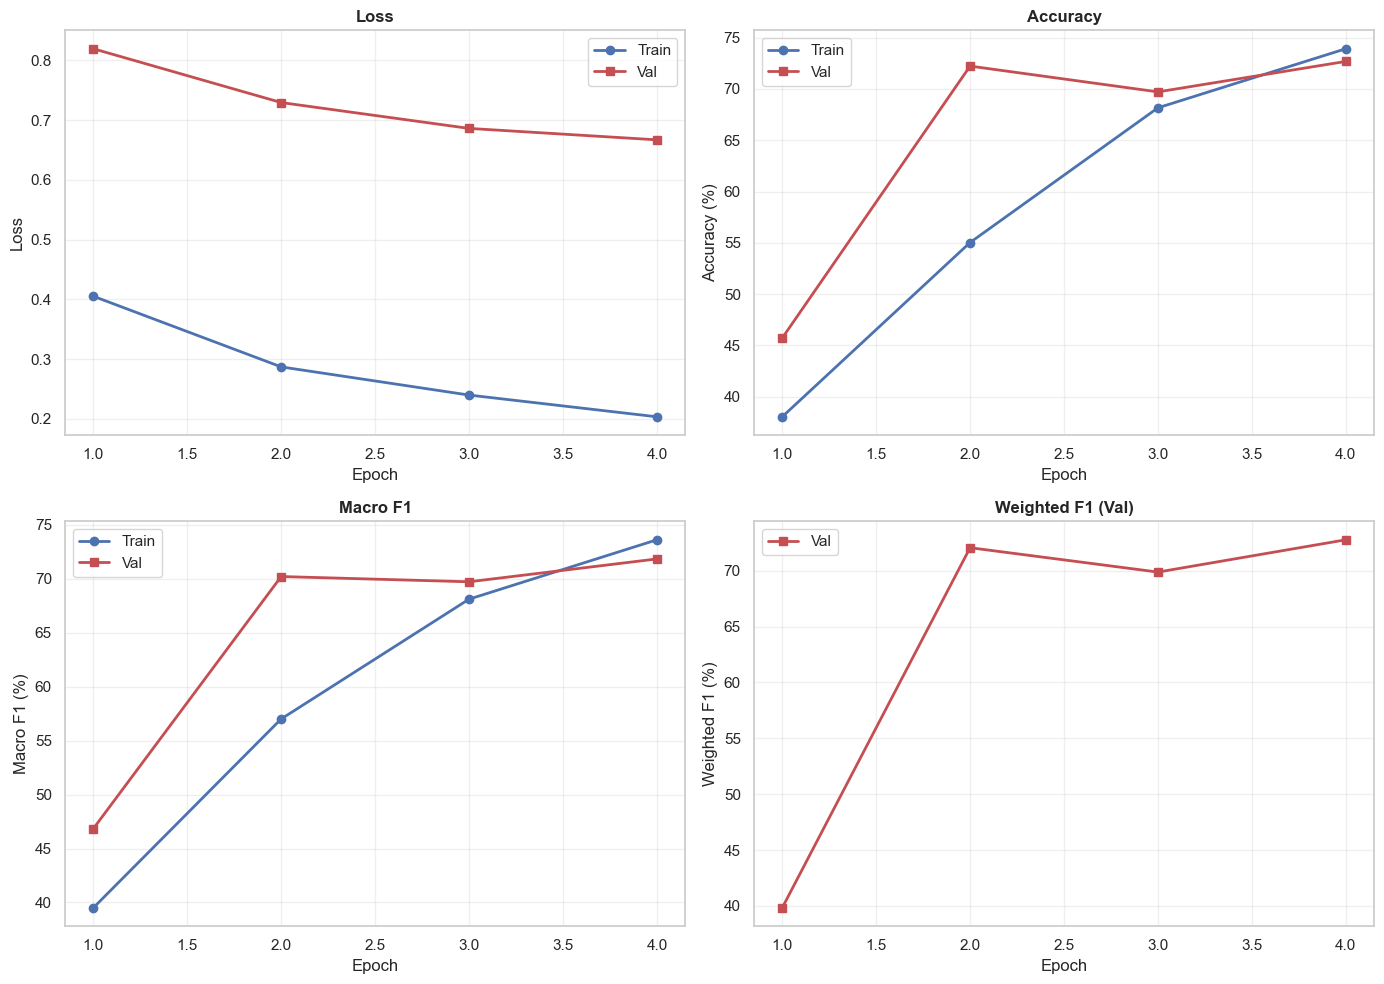


Quick Analysis:
  ✅ Good generalization (gap: 1.24%)
  ✅ Validation loss improved


In [24]:
if 'history' in globals():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0, 0].plot(epochs_range, history['train_loss'], 'b-o', label='Train', linewidth=2)
    axes[0, 0].plot(epochs_range, history['val_loss'], 'r-s', label='Val', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(epochs_range, [x*100 for x in history['train_acc']], 'b-o', label='Train', linewidth=2)
    axes[0, 1].plot(epochs_range, [x*100 for x in history['val_acc']], 'r-s', label='Val', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Accuracy', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Macro F1
    axes[1, 0].plot(epochs_range, [x*100 for x in history['train_macro_f1']], 'b-o', label='Train', linewidth=2)
    axes[1, 0].plot(epochs_range, [x*100 for x in history['val_macro_f1']], 'r-s', label='Val', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Macro F1 (%)')
    axes[1, 0].set_title('Macro F1', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Weighted F1
    axes[1, 1].plot(epochs_range, [x*100 for x in history['val_weighted_f1']], 'r-s', label='Val', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Weighted F1 (%)')
    axes[1, 1].set_title('Weighted F1 (Val)', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Quick analysis
    train_acc = history['train_acc'][-1]
    val_acc = history['val_acc'][-1]
    gap = train_acc - val_acc
    
    print("\nQuick Analysis:")
    if gap < 0.05:
        print(f"  ✅ Good generalization (gap: {gap:.2%})")
    elif gap < 0.10:
        print(f"  ⚠️  Slight overfitting (gap: {gap:.2%})")
    else:
        print(f"  ❌ Overfitting detected (gap: {gap:.2%})")
    
    if history['val_loss'][-1] < history['val_loss'][0]:
        print("  ✅ Validation loss improved")
    else:
        print("  ⚠️  Validation loss increased")
else:
    print("Load training results first.")

## Compare Multiple Runs (Optional)

In [25]:
# Compare recent training runs
import pandas as pd

runs_dir = PROJECT_ROOT / "models" / "runs"

if runs_dir.exists():
    run_dirs = sorted([d for d in runs_dir.iterdir() if d.is_dir()], reverse=True)
    
    runs_data = []
    for run_dir in run_dirs[:10]:  # Last 10 runs
        history_path = run_dir / "training_history.json"
        if history_path.exists():
            with open(history_path, 'r') as f:
                h = json.load(f)
            
            runs_data.append({
                'run': run_dir.name,
                'epochs': len(h['train_loss']),
                'loss_fn': h.get('loss_function', 'CE'),
                'monitor': h.get('monitor_metric', 'acc'),
                'best_epoch': h.get('best_metric_epoch'),
                'best_value': h.get('best_metric_value'),
                'final_val_acc': h['val_acc'][-1],
                'final_val_f1': h['val_macro_f1'][-1],
                'weights': str([round(w, 2) for w in h['class_weights']]) if h.get('class_weights') else 'None'
            })
    
    if runs_data:
        df_runs = pd.DataFrame(runs_data)
        print("Recent Training Runs:\n")
        print(df_runs.to_string(index=False))
    else:
        print("No run histories found.")
else:
    print("No runs directory found.")

Recent Training Runs:

            run  epochs loss_fn  monitor  best_epoch  best_value  final_val_acc  final_val_f1            weights
20251113-225730       4   focal macro_f1           4    0.686490       0.684571      0.686490   [1.5, 1.0, 1.25]
20251113-224046       4   focal macro_f1           4    0.743549       0.761143      0.743549   [1.5, 1.0, 1.25]
20251113-215653       4   focal macro_f1           4    0.498762       0.664000      0.498762   [1.5, 1.0, 1.25]
20251113-212550       4   focal macro_f1           4    0.718366       0.726857      0.718366 [1.62, 0.62, 1.25]


## Decision: Proceed to Full Evaluation?

In [21]:
if 'history' in globals():
    val_acc = history['val_acc'][-1]
    val_f1 = history['val_macro_f1'][-1]
    
    print("Model Performance Summary:")
    print(f"  Final Val Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"  Final Val Macro F1: {val_f1:.4f} ({val_f1*100:.2f}%)")
    
    print("\nRecommendation:")
    if val_acc > 0.75 and val_f1 > 0.70:
        print("  ✅ Model looks good! Proceed to full evaluation:")
        print("     python scripts/03_evaluate_model.py")
    elif val_acc > 0.65 and val_f1 > 0.60:
        print("  ⚠️  Model is okay but could be better. Consider:")
        print("     - Adjusting class weights")
        print("     - More epochs")
        print("     - Different loss function")
    else:
        print("  ❌ Model performance is weak. Try:")
        print("     - Check data quality")
        print("     - Adjust hyperparameters")
        print("     - Review class balance")
else:
    print("Load training results first.")

Model Performance Summary:
  Final Val Accuracy: 0.7269 (72.69%)
  Final Val Macro F1: 0.7184 (71.84%)

Recommendation:
  ⚠️  Model is okay but could be better. Consider:
     - Adjusting class weights
     - More epochs
     - Different loss function


## Validation Set Analysis

In [26]:


if 'latest_run' not in globals():
    print("Run the training summary cell first to set latest_run.")
else:
    model_path = latest_run / "trained_sentiment_electra"
    val_data_path = PROJECT_ROOT / "data" / "processed" / "val.csv"
    
    if not model_path.exists():
        print(f"Model not found at {model_path}")
    elif not val_data_path.exists():
        print(f"Validation data not found at {val_data_path}")
    else:
        print(f"Loading model from {model_path}")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        tokenizer = ElectraTokenizerFast.from_pretrained(str(model_path))
        model = ElectraForSequenceClassification.from_pretrained(str(model_path))
        model.to(device)
        model.eval()
        
        print(f"Loading validation data from {val_data_path}")
        val_df = pd.read_csv(val_data_path)
        
        # Import the dataset class
        from src.model import SentimentDataset
        val_dataset = SentimentDataset(
            texts=val_df['text'].values,
            labels=val_df['label'].values,
            tokenizer=tokenizer,
            max_length=128
        )
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        print("Running predictions on validation set...")
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=-1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        y_true = np.array(all_labels)
        y_pred = np.array(all_preds)
        
        print(f"Predictions complete: {len(y_true)} samples")

ModuleNotFoundError: No module named 'torch'

In [ ]:
# Confusion Matrix Visualization
if 'y_true' in globals() and 'y_pred' in globals():
    class_names = ['Negative', 'Neutral', 'Positive']
    cm = confusion_matrix(y_true, y_pred)
    cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    ax1.set_ylabel('True Label', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
    ax1.set_title('Counts', fontweight='bold', fontsize=14)
    
    # Percentages
    sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': '%'})
    ax2.set_ylabel('True Label', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
    ax2.set_title('Percentages', fontweight='bold', fontsize=14)
    
    plt.suptitle('Validation Set Confusion Matrix', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Run the prediction cell first to generate y_true and y_pred.")

In [ ]:
# Per-Class Metrics Summary
if 'y_true' in globals() and 'y_pred' in globals():
    class_names = ['Negative', 'Neutral', 'Positive']
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    
    # Convert to DataFrame for nice display
    report_df = pd.DataFrame(report).transpose()
    
    # Select key rows and columns
    metrics_df = report_df.loc[
        ['Negative', 'Neutral', 'Positive', 'macro avg', 'weighted avg'],
        ['precision', 'recall', 'f1-score', 'support']
    ].copy()
    
    # Round for display
    metrics_df[['precision', 'recall', 'f1-score']] = metrics_df[['precision', 'recall', 'f1-score']].round(4)
    metrics_df['support'] = metrics_df['support'].astype(int)
    
    print("=" * 80)
    print("VALIDATION SET METRICS SUMMARY")
    print("=" * 80)
    print(metrics_df.to_string())
    print("=" * 80)
    
    # Highlight key insights
    print("\nKey Insights:")
    for cls in ['Negative', 'Neutral', 'Positive']:
        prec = metrics_df.loc[cls, 'precision']
        rec = metrics_df.loc[cls, 'recall']
        f1 = metrics_df.loc[cls, 'f1-score']
        sup = int(metrics_df.loc[cls, 'support'])
        
        status = "✅" if f1 >= 0.70 else "⚠️" if f1 >= 0.60 else "❌"
        print(f"  {status} {cls:8s}: F1={f1:.4f} (P={prec:.4f}, R={rec:.4f}) [{sup} samples]")
else:
    print("Run the prediction cell first to generate y_true and y_pred.")